In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-revenue-prediction/train.csv.zip
/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv
/kaggle/input/restaurant-revenue-prediction/test.csv.zip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = '../input/restaurant-revenue-prediction/train.csv.zip'
df_train = pd.read_csv(train_path)
df_train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [4]:
test_path = '../input/restaurant-revenue-prediction/test.csv.zip'
df_test = pd.read_csv(test_path, index_col='Id')
df_test.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
Id,,,,,,,,,,,,,,,,,,,,,
0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,...,2.0,3.0,0,0,0,0,0,0,0,0
1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,...,2.0,3.0,0,4,0,0,0,0,0,0
4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,...,5.0,3.0,0,0,0,0,0,0,0,0


**Create new attribute called "Age" which means how long have the restaunrant opened.**

In [5]:
from datetime import date, datetime

def calculate_age(born):
        born = datetime.strptime(born, "%m/%d/%Y").date()
        today = date.today()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df_train['Age'] = df_train['Open Date'].apply(calculate_age)
df_test['Age'] = df_test['Open Date'].apply(calculate_age)

# Drop 'Open Date' column from Dataframes
df_train = df_train.drop('Open Date', axis=1)
df_test = df_test.drop('Open Date', axis=1)

# Drop 'Id' column from Dataframes
df_train = df_train.drop('Id', axis=1)

df_train.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Age
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,5,3,4,5,5,4,3,4,5653753.0,21
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,0,0,6923131.0,12
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,...,0,0,0,0,0,0,0,0,2055379.0,7
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,...,25,12,10,6,18,12,12,6,2675511.0,8
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,...,5,1,3,2,3,4,3,3,4316715.0,11


# **2. Data Exploration**
**In this phase, we are going to explore the featrue relations**

In [6]:
# Find the sets of categorical variables and numberical variales for feature analyses 
numerical_features = df_train.select_dtypes([np.number]).columns.tolist()
categorical_features = df_train.select_dtypes(exclude = [np.number,np.datetime64]).columns.tolist()
print(categorical_features)
print(numerical_features)

['City', 'City Group', 'Type']
['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue', 'Age']


First, analyzing target variable 'revenue'

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64


[Text(0, 0.5, 'P(revenue)'), Text(0.5, 0, 'revenue')]

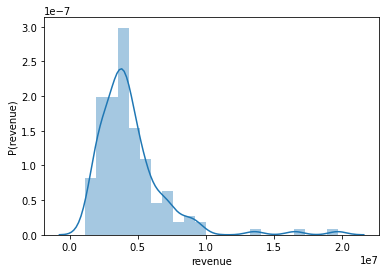

In [7]:
print(df_train['revenue'].describe())
sns.distplot(a=df_train['revenue'], kde=True).set(xlabel='revenue', ylabel='P(revenue)')

The histogram is showing that target vaiable is a right-skewed distribution. <br/>
There are outliers which have revenue >10.000.000 will effect the results. These outliers should be removed from the dataset.

In [8]:
df_train[df_train['revenue'] > 10000000 ]

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Age
16,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,5,5,...,0,0,0,0,0,0,0,0,19696939.0,21
75,İstanbul,Big Cities,FC,5,5.0,4.0,5.0,1,4,5,...,0,0,0,0,0,0,0,0,16549064.0,15
99,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,4,5,...,5,5,4,2,5,5,5,3,13575224.0,21


In [9]:
# Drop outliers
df_train = df_train[df_train['revenue'] < 10000000 ]
df_train.reset_index(drop=True).head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Age
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,5,3,4,5,5,4,3,4,5653753.0,21
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,0,0,6923131.0,12
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,...,0,0,0,0,0,0,0,0,2055379.0,7
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,...,25,12,10,6,18,12,12,6,2675511.0,8
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,...,5,1,3,2,3,4,3,3,4316715.0,11


### **Analyzing numerical features distribution**

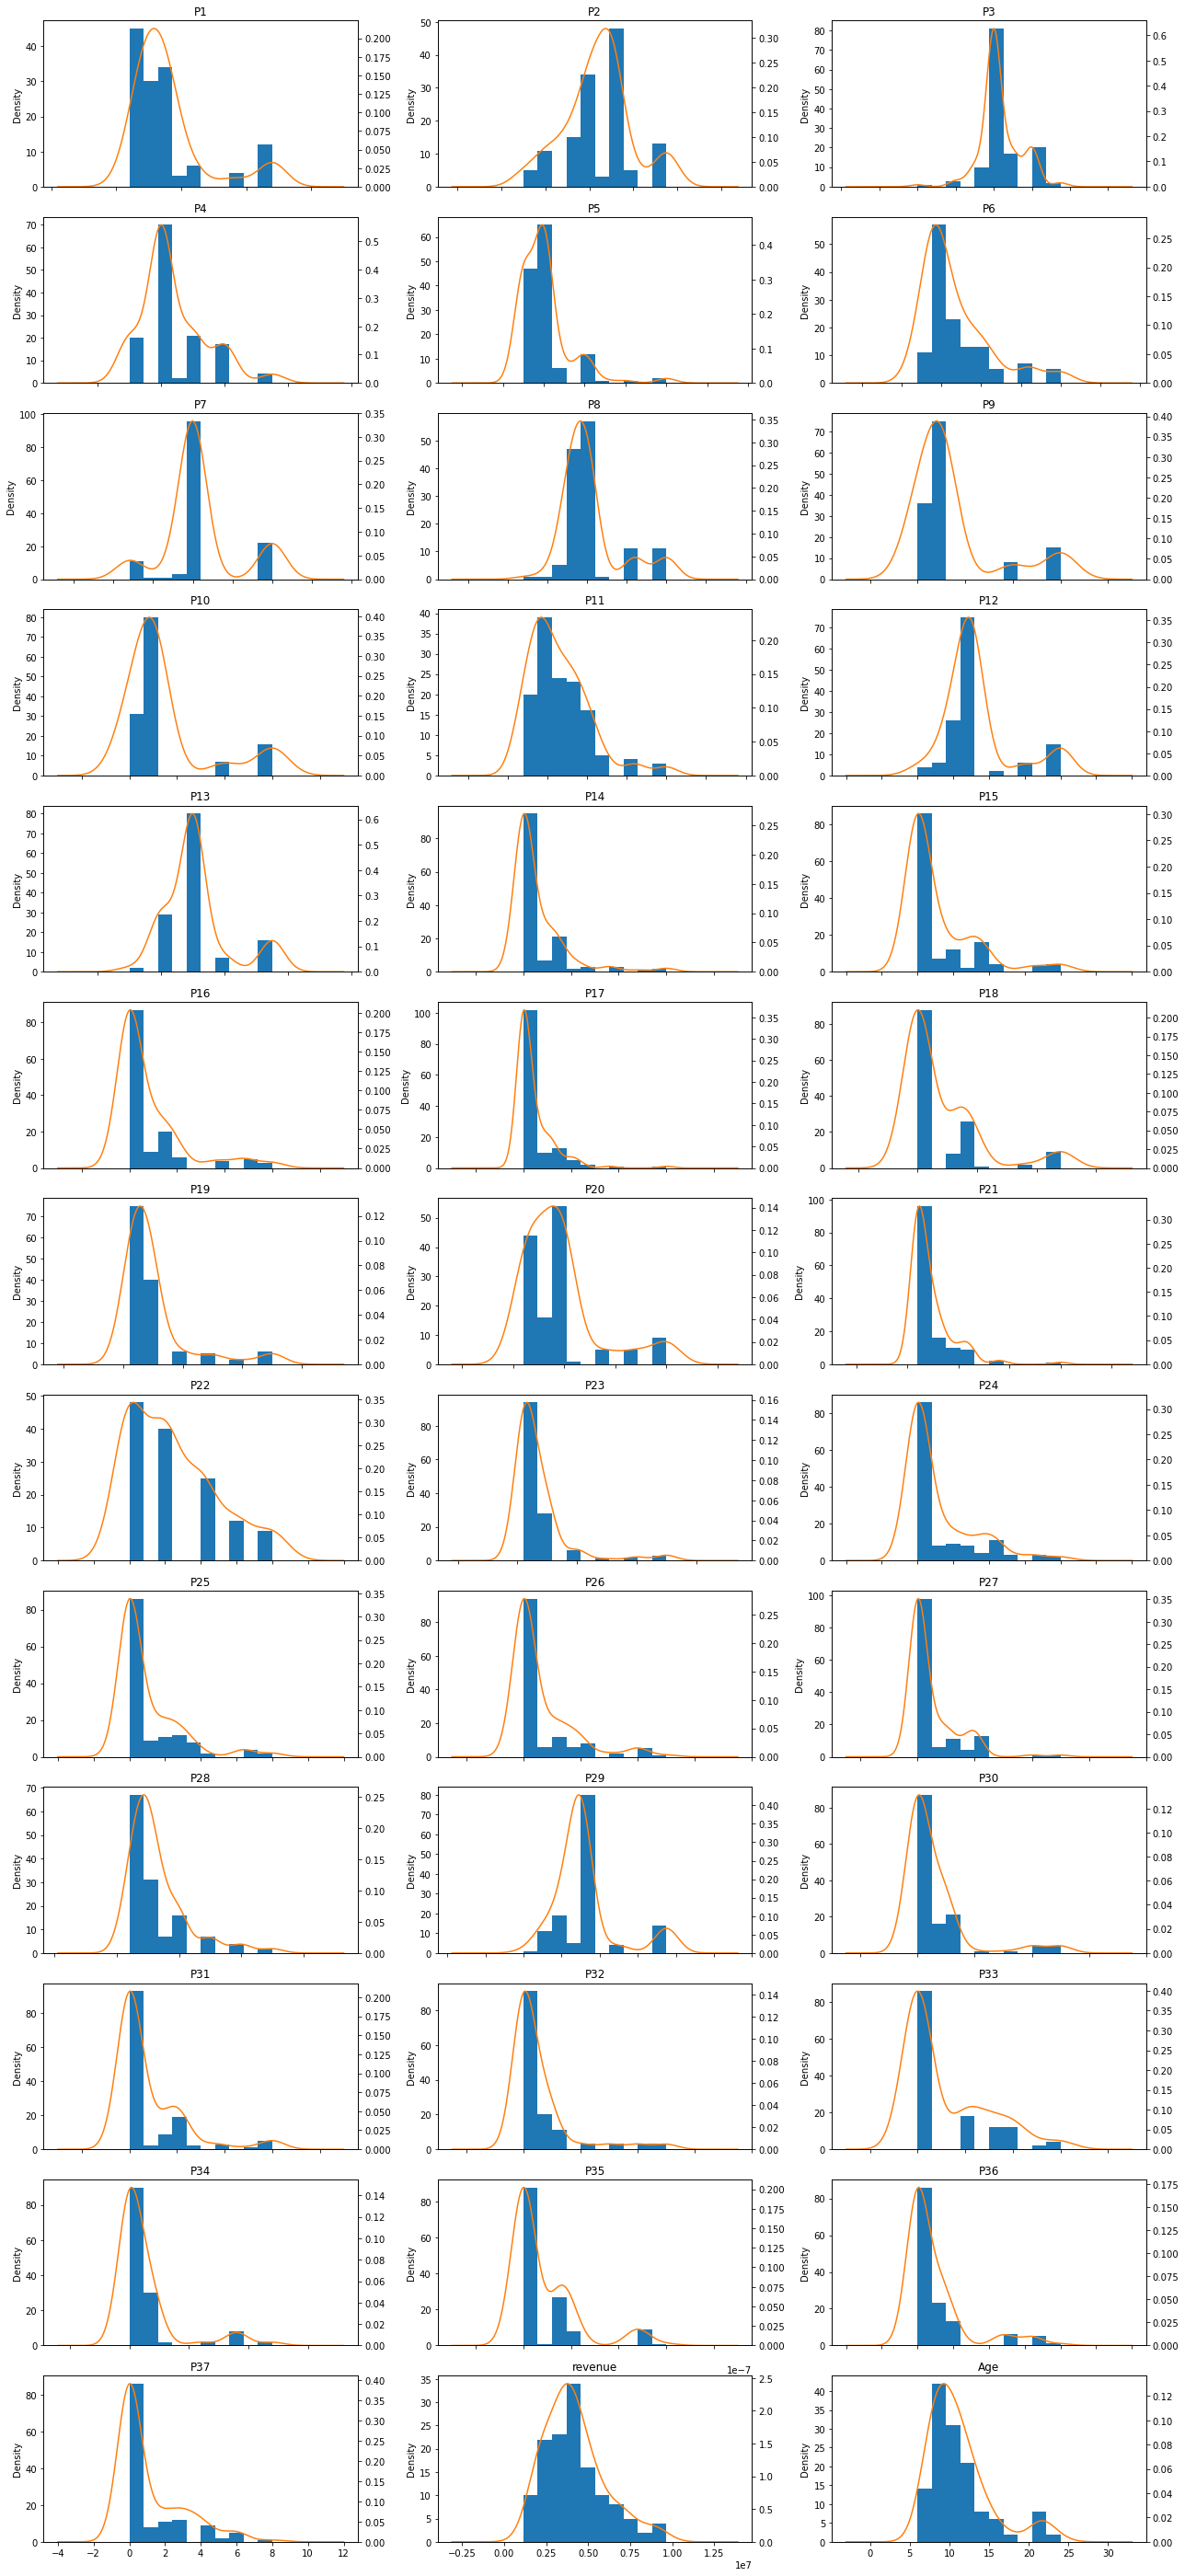

In [10]:
n = len(df_train[numerical_features].columns)
w = 3
h = (n - 1) // w + 1
fig, axes = plt.subplots(h, w, figsize=(w * 6, h * 3))
for i, (name, col) in enumerate(df_train[numerical_features].items()):
    r, c = i // w, i % w
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)

fig.tight_layout()

**According to these histograms, it is clearly showing that most of the distributions are right-skewed. These non-normal distributions need to be studied carefully.** <br/>

**Analyzing categorical featrues**

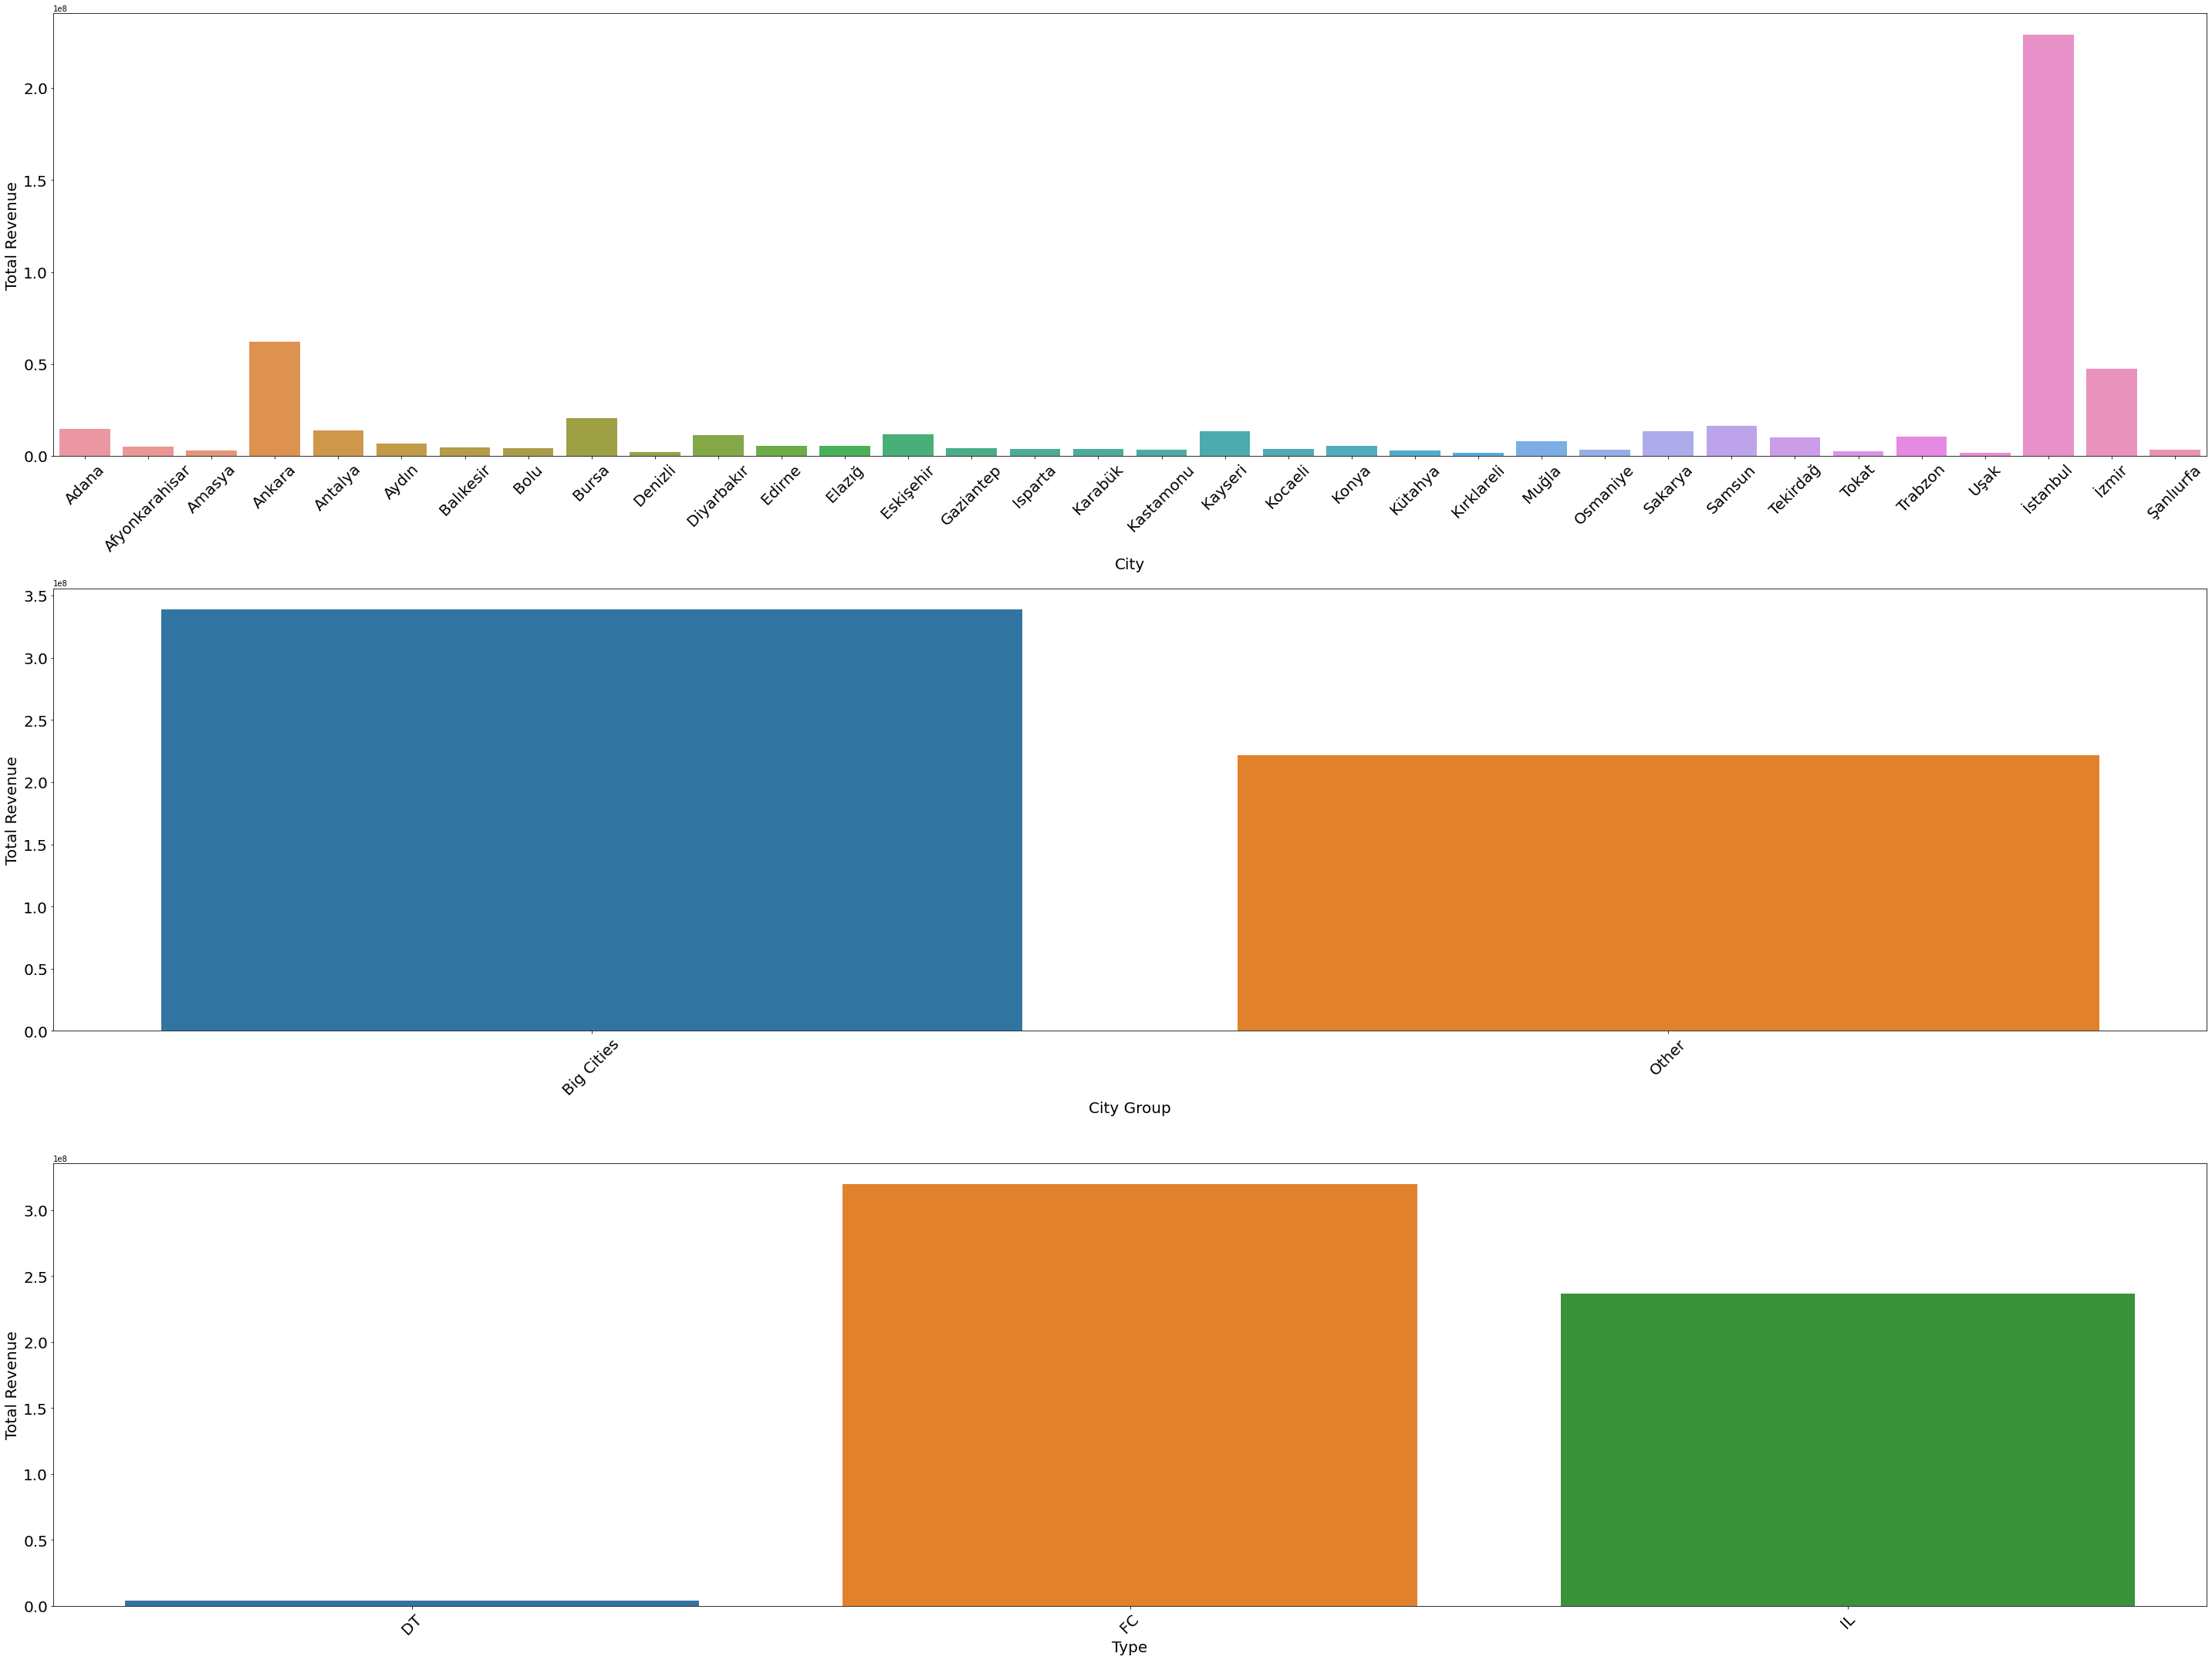

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(40, 30))
for variable, subplot in zip(categorical_features, ax.flatten()):
    df_2 = df_train[[variable,'revenue']].groupby(variable).revenue.sum().reset_index()
    df_2.columns = [variable,'total_revenue']
    sns.barplot(x=variable, y='total_revenue', data=df_2 , ax=subplot)
    subplot.set_xlabel(variable,fontsize=20)
    subplot.set_ylabel('Total Revenue',fontsize=20)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
        label.set_size(20)
    for label in subplot.get_yticklabels():
        label.set_size(20)
fig.tight_layout()

1. Restaurants in Istabul earn the most revenue in the dataset.
2. Restaurants in the big cities have higher total revenue than the others.
3. Restaurants in FC and IL city types have much higher total revenue than DT city type.

## **Relationships Between Attributes and Target Variables "Revenue"**

### **A. Numerical Attributes**

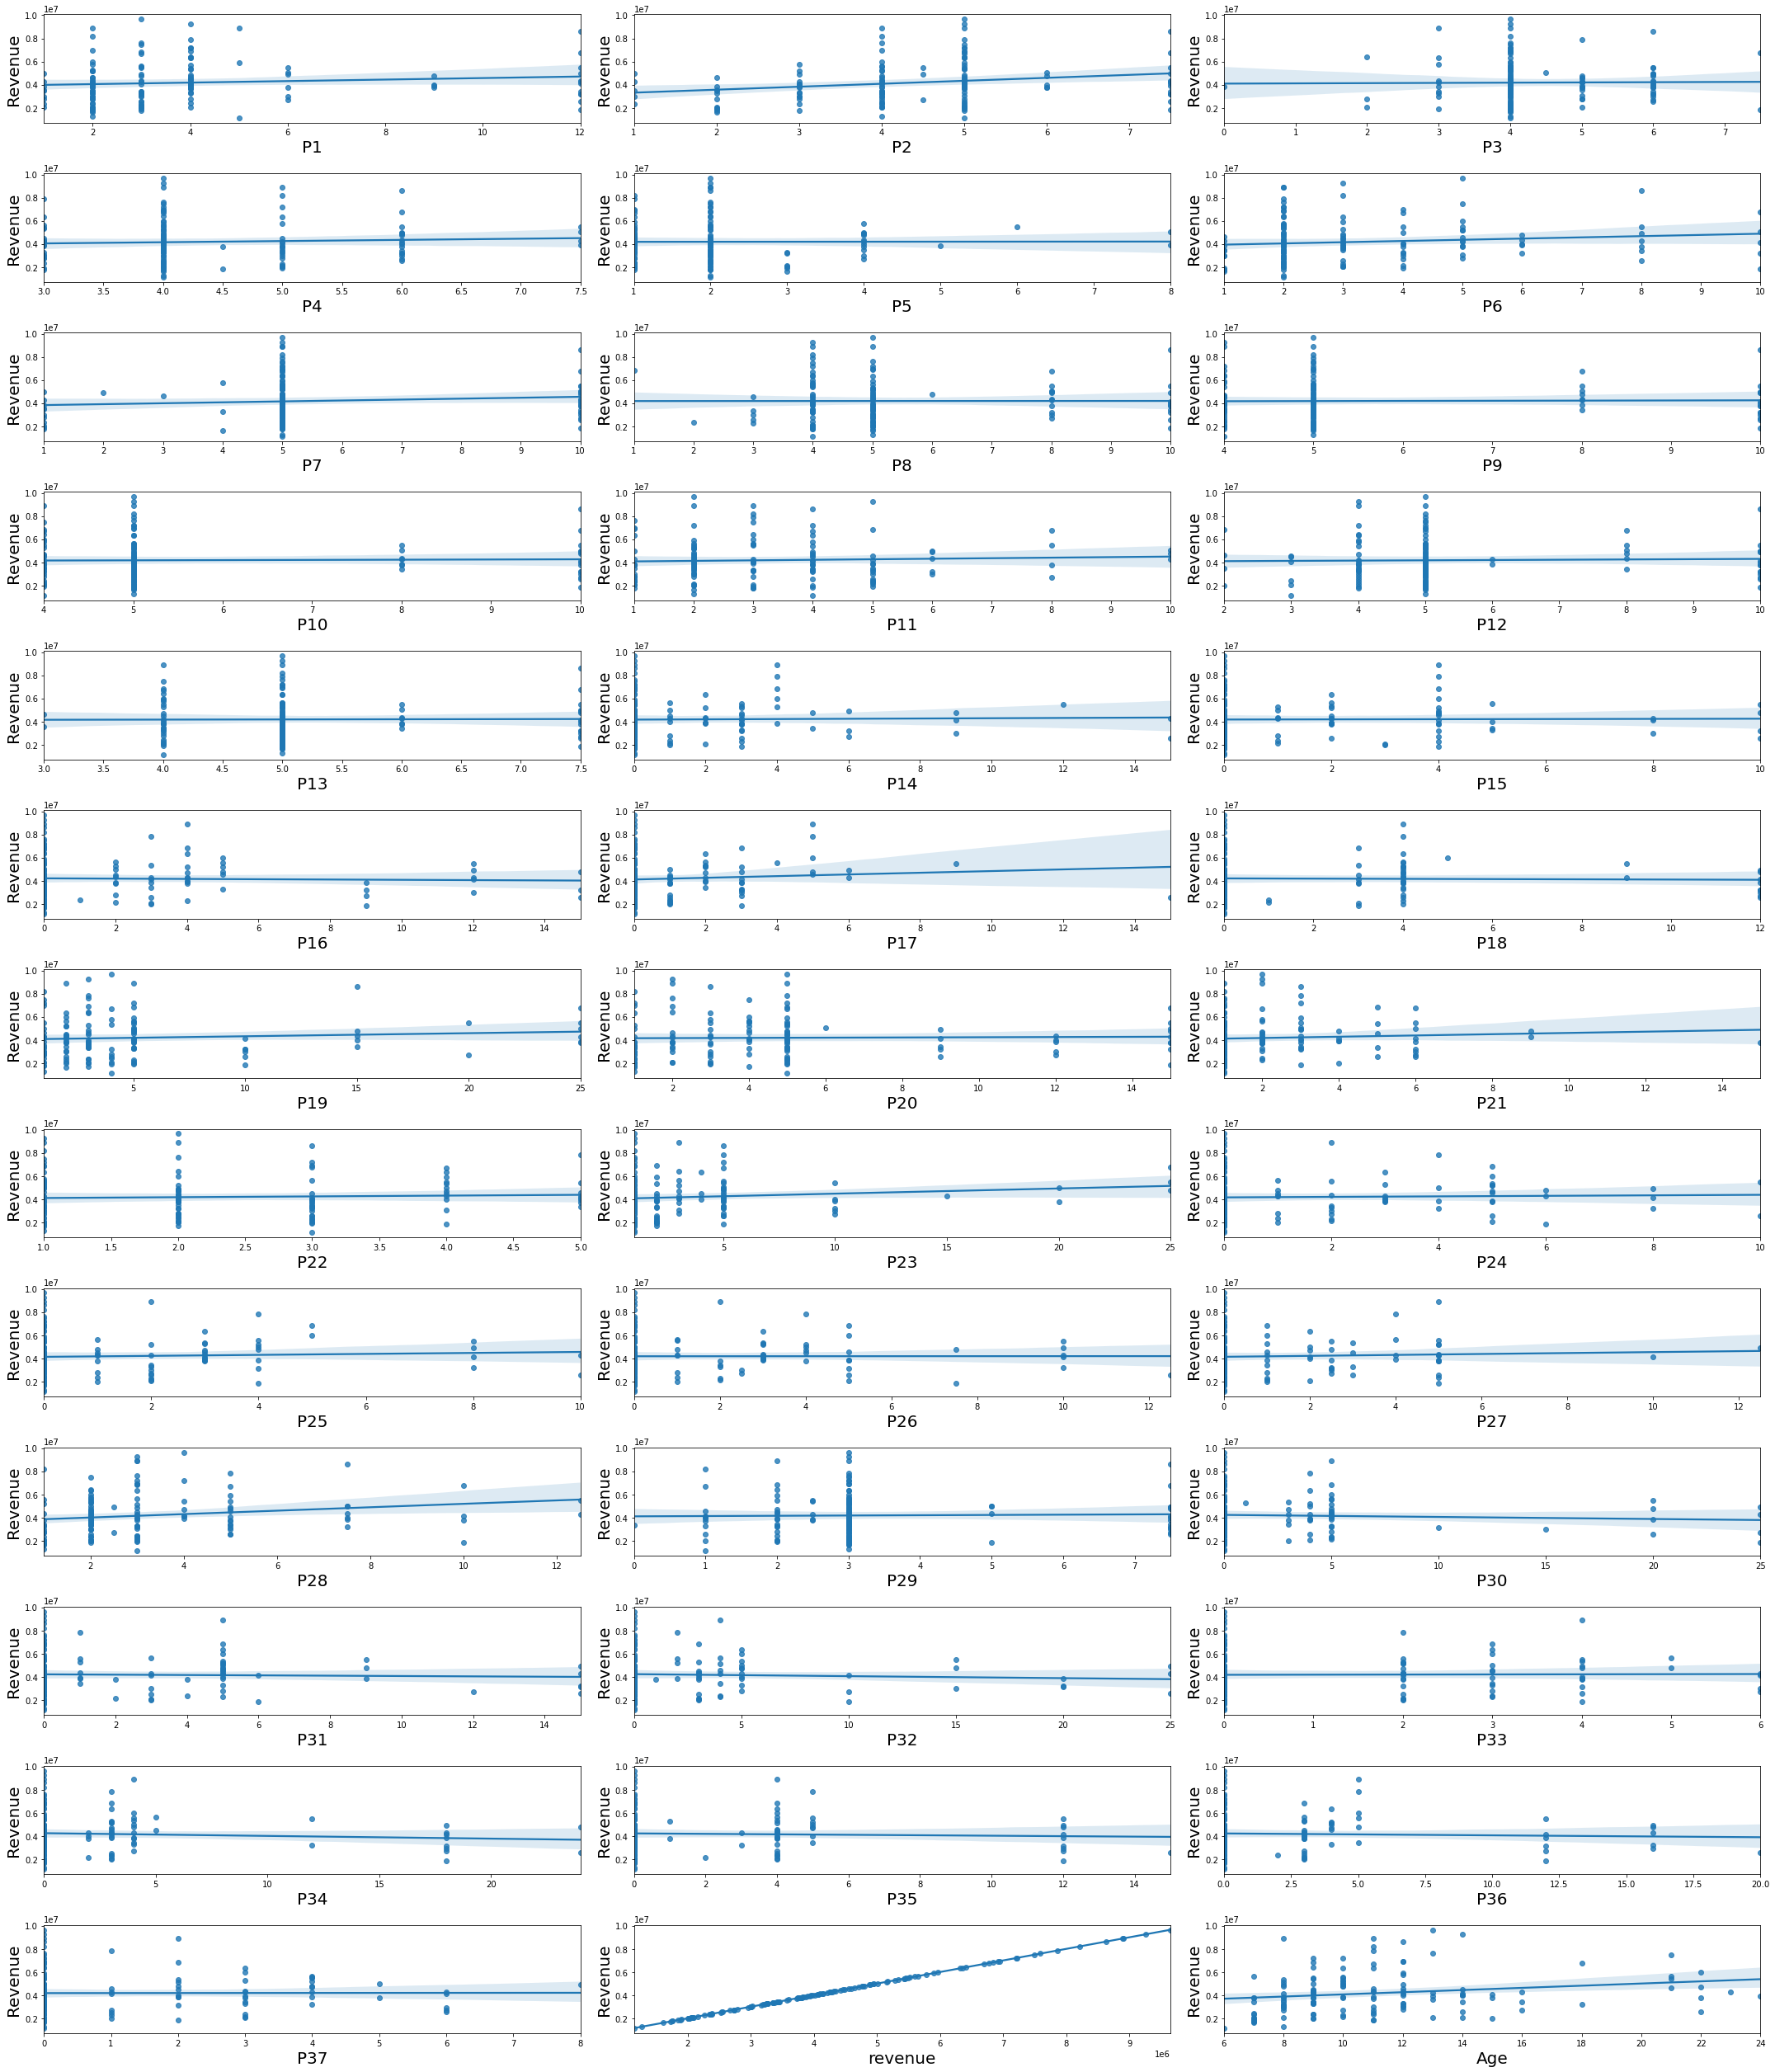

In [12]:
fig, ax = plt.subplots(13, 3, figsize=(30, 35))
for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.regplot(x=df_train[variable], y=df_train['revenue'], ax=subplot)
    subplot.set_xlabel(variable,fontsize=20)
    subplot.set_ylabel('Revenue',fontsize=20)
fig.tight_layout()

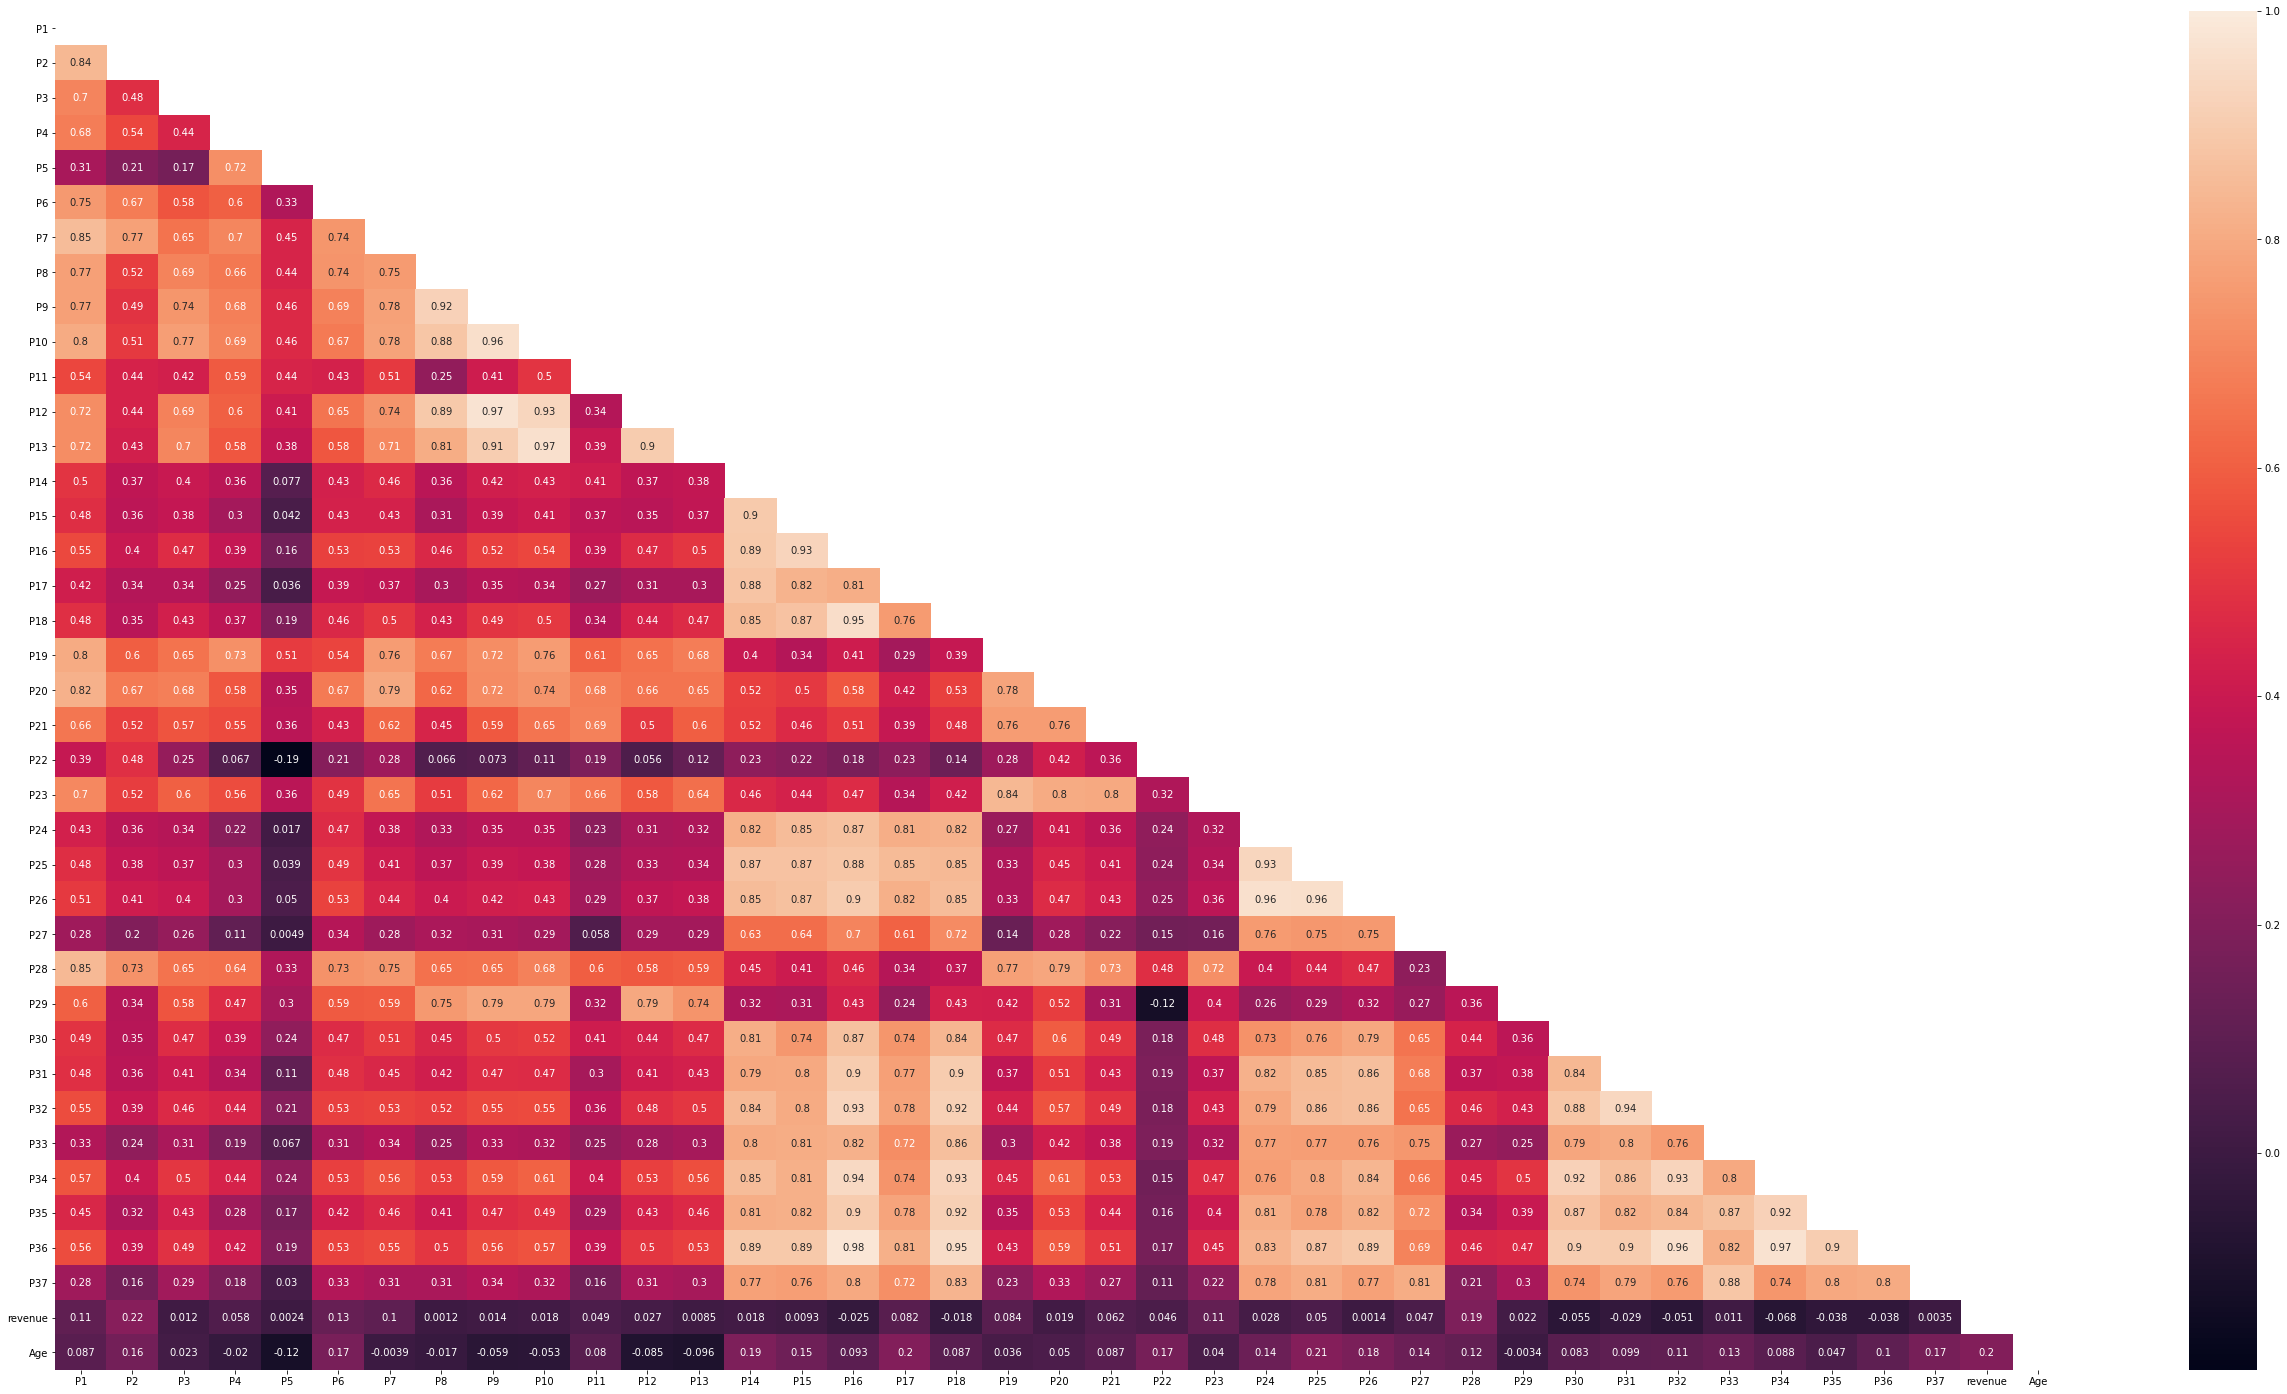

In [13]:
plt.figure(figsize=(45,25))
mask = np.triu(np.ones_like(df_train.corr(), dtype=np.bool))
sns.heatmap(df_train.corr(),annot=True, mask=mask)
sns.set(font_scale=1.4)

**According to linear regression graphs and heatmap of correlation scores, these numerical attributes have very weak linear relationship with the target variable "Revenue". The highest correlation score is 'Age' which is 0.2, meanwhile the others have nearly 0 correlation score.
However, there are groups of attributes which have high correlation to each others.**

# **b. Categorical Attributes**

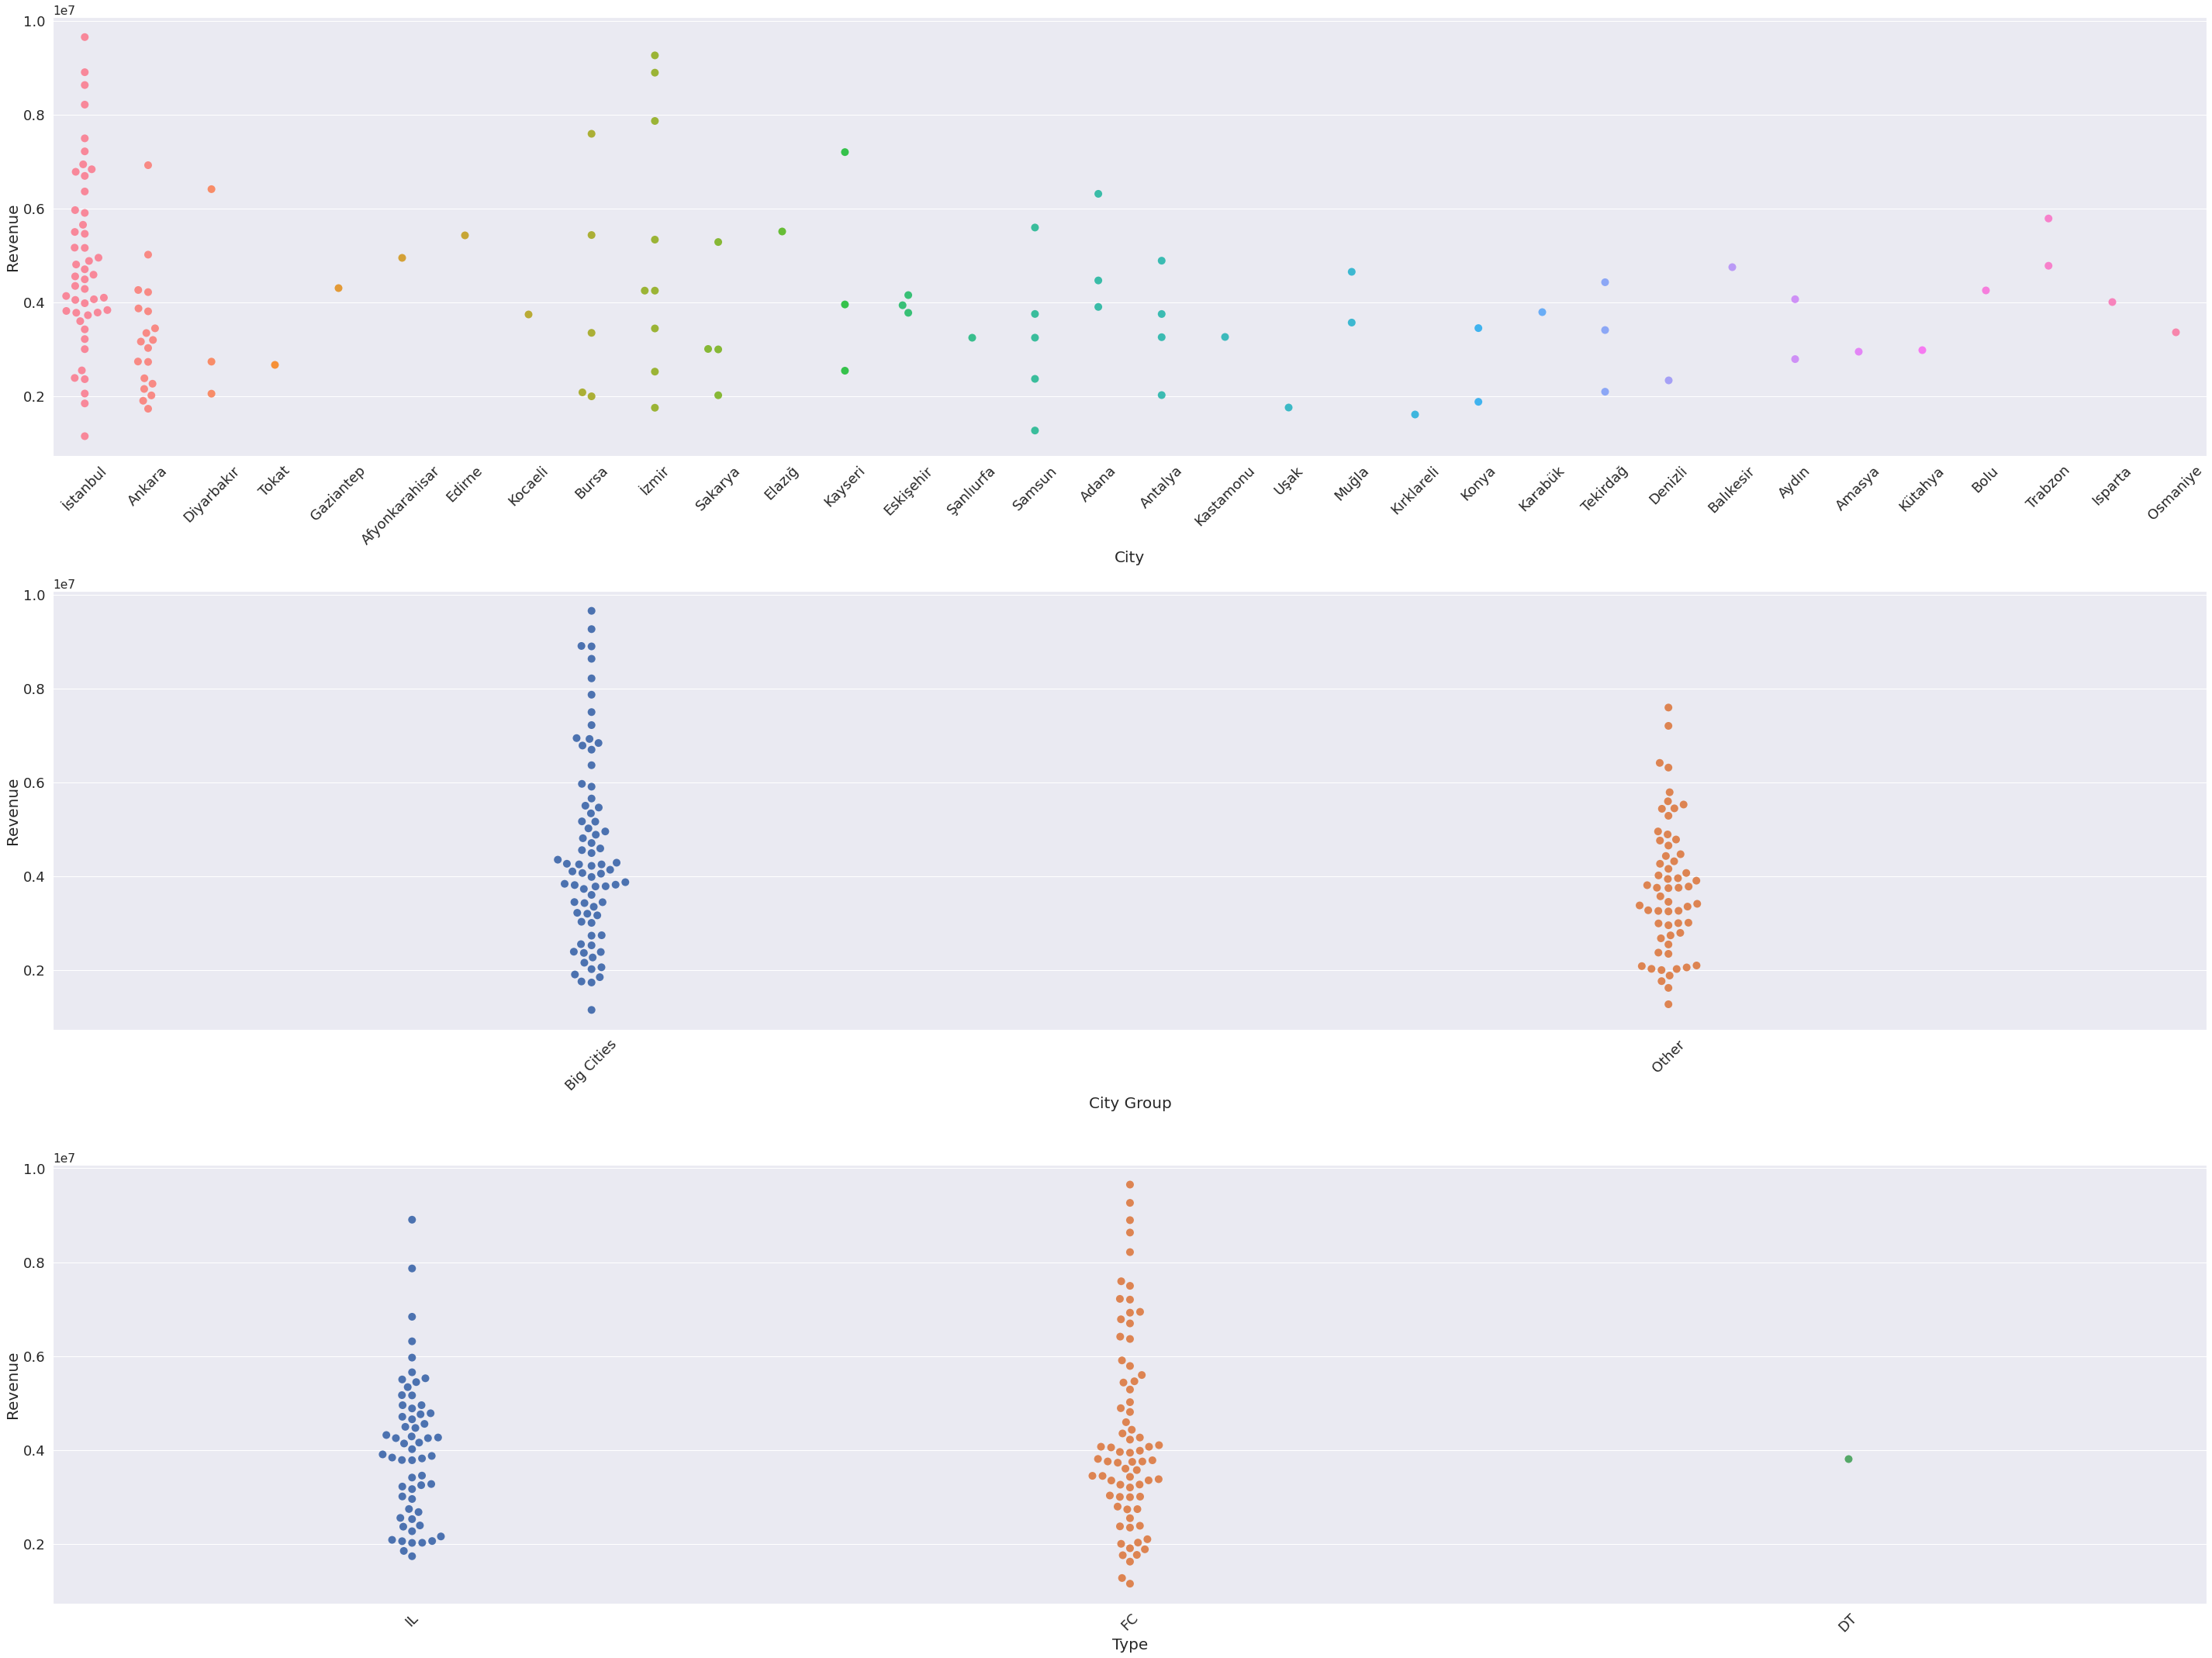

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(40, 30))
for variable, subplot in zip(categorical_features, ax.flatten()):
    sns.swarmplot(x=variable, y='revenue', data=df_train, ax=subplot,size=10)
    subplot.set_xlabel(variable,fontsize=20)
    subplot.set_ylabel('Revenue',fontsize=20)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
        label.set_size(18)
    for label in subplot.get_yticklabels():
        label.set_size(18)
fig.tight_layout()

In [15]:
#Lets take a look at city group field 
print("--- Train set ---")
print(df_train['City Group'].value_counts())
print("---- Test set ----")
print(df_test['City Group'].value_counts())

--- Train set ---
Big Cities    75
Other         59
Name: City Group, dtype: int64
---- Test set ----
Other         50728
Big Cities    49272
Name: City Group, dtype: int64


In [16]:
#Lets take a look at type field 
print("--- Train set ---")
print(df_train['Type'].value_counts())
print("---- Test set ----")
print(df_test['Type'].value_counts())


--- Train set ---
FC    74
IL    59
DT     1
Name: Type, dtype: int64
---- Test set ----
FC    57019
IL    40447
DT     2244
MB      290
Name: Type, dtype: int64


**There is no MB restaurant type in the train dataset.**

# **3. Data Preparation**

In [17]:
y = df_train['revenue']
df_train=df_train.drop('revenue', axis=1)

In [18]:
print("Shapes: Train set ", df_train.shape ,", Test ",df_test.shape)
df_full = pd.concat([df_train,df_test])
print("Full dataset shapes: ", df_full.shape)

Shapes: Train set  (134, 41) , Test  (100000, 41)
Full dataset shapes:  (100134, 41)


In [19]:
print('There are {} cities which restaurant location have been collected.'.format(len(df_full['City'].unique())))

There are 63 cities which restaurant location have been collected.


Since the number of cities is too many and it is not useful for prediction or classification, this feature can be dropped.

In [20]:
df_full = df_full.drop('City', axis=1)
df_full.shape

(100134, 40)

In [21]:
p_name = ['P'+str(i) for i in range(1,38)]

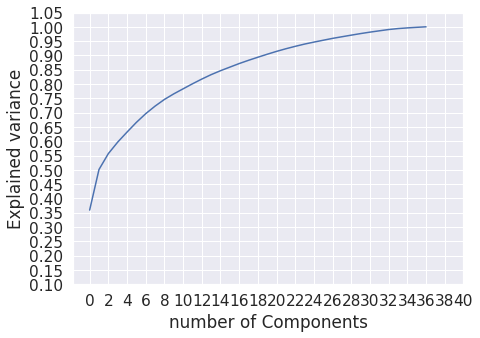

In [22]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_full[p_name])
plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of Components')
plt.ylabel('Explained variance')
plt.yticks(np.arange(0.1,1.1,0.05))
plt.xticks(np.arange(0,41,2))
plt.grid(True)

In [23]:
pca_list = ['pca'+str(i) for i in range(1,30,1)]
df_full[pca_list] = PCA(n_components=29).fit_transform(df_full[p_name])
df_full.drop(p_name,axis=1,inplace=True)

In [24]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100134 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City Group  100134 non-null  object 
 1   Type        100134 non-null  object 
 2   Age         100134 non-null  int64  
 3   pca1        100134 non-null  float64
 4   pca2        100134 non-null  float64
 5   pca3        100134 non-null  float64
 6   pca4        100134 non-null  float64
 7   pca5        100134 non-null  float64
 8   pca6        100134 non-null  float64
 9   pca7        100134 non-null  float64
 10  pca8        100134 non-null  float64
 11  pca9        100134 non-null  float64
 12  pca10       100134 non-null  float64
 13  pca11       100134 non-null  float64
 14  pca12       100134 non-null  float64
 15  pca13       100134 non-null  float64
 16  pca14       100134 non-null  float64
 17  pca15       100134 non-null  float64
 18  pca16       100134 non-null  float64
 19  pca

To deal with categorical variables, we need to convert it to numerical format by either encoding categories or creating dummies. <br/>
In this project, dummies will be used.

In [25]:
df=pd.get_dummies(df_full, dtype=float)

Now, the dataframe contain numerical attributes only. We can move to the next stage.<br/>
Remember, we have combined both train set and test set for data preparation. we need to split it into train set and test set for data modelling.

In [26]:
# Get number of train sets
numTrain=df_train.shape[0]

train = df[:numTrain]
test = df[numTrain:]

**Normalize dependent variable**

[Text(0, 0.5, 'P(revenue)'), Text(0.5, 0, 'revenue')]

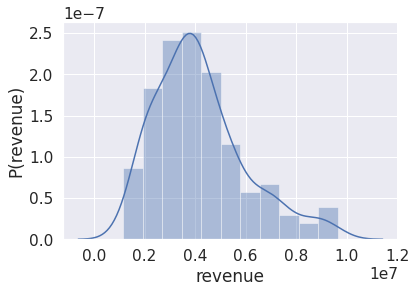

In [27]:
sns.distplot(a=y, kde=True).set(xlabel='revenue', ylabel='P(revenue)')

1. Skewness is a measure of symmetry, or more precisely, the lack of symmetry.
2. Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.

In [28]:
print("Kurtosis: {}".format(y.kurt()))
print("Skewness: {}".format(y.skew()))

Kurtosis: 0.6027289685209611
Skewness: 0.8952934755058413


# **Split data into train/test sets for data modelling**

In [29]:
from sklearn.model_selection import train_test_split

# Split the data into train and test set
X_train, X_test, y_train, y_test =  train_test_split(train,y,test_size=0.3,random_state=42)
print("Shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes:  (93, 36) (41, 36) (93,) (41,)


# **4. Data Modelling**

In [30]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


In [31]:
best_estimators=[]

## **A. Model parameter tuning**

Ridge

In [32]:
## Parameters
params = {
    "alpha" : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    "fit_intercept" : [True, False],
    "normalize" : [True,False],
    "solver" : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    "tol" : [0.0001, 0.001, 0.01, 0.1],
    "random_state" : [42]
}

## Ridge
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, params, scoring='r2', cv=5, n_jobs=-1)
ridge_grid.fit(X_train, y_train)

## Output
print("Best parameters:  {}:".format(ridge_grid.best_params_))
print("Best score: {}".format(ridge_grid.best_score_))

## Append to list
best_estimators.append(["Ridge",ridge_grid.best_estimator_])

Best parameters:  {'alpha': 0.5, 'fit_intercept': True, 'normalize': True, 'random_state': 42, 'solver': 'saga', 'tol': 0.1}:
Best score: 0.02194757455367493


Lasso Regressor

In [33]:
params = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'tol' : [0.0001, 0.001, 0.01, 0.1],
    "random_state" : [42]
}

## Lasso
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, params, scoring='r2', cv=5, n_jobs=-1)
lasso_grid.fit(X_train, y_train)

## Output
print("Best parameters:  {}:".format(lasso_grid.best_params_))
print("Best score: {}".format(lasso_grid.best_score_))

## Append to list
best_estimators.append(["Lasso",lasso_grid.best_estimator_])

Best parameters:  {'alpha': 20, 'fit_intercept': True, 'normalize': True, 'random_state': 42, 'tol': 0.0001}:
Best score: -1.1050960692490346


Elastic-Net

In [34]:
# Parameters
params = {
    "alpha" : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    "fit_intercept" : [True, False],
    "normalize" : [True,False],
    "tol" : [0.0001, 0.001, 0.01, 0.1],
    "random_state" : [42]
}

## Elastic Net
EL = ElasticNet()
EL_grid = GridSearchCV(EL, params, scoring='r2', cv=5, n_jobs=-1)
EL_grid.fit(X_train, y_train)

## Output
print("Best parameters:  {}:".format(EL_grid.best_params_))
print("Best score: {}".format(EL_grid.best_score_))

## Append to list
best_estimators.append(["ElasticNet",EL_grid.best_estimator_])

Best parameters:  {'alpha': 0.1, 'fit_intercept': True, 'normalize': True, 'random_state': 42, 'tol': 0.1}:
Best score: 0.002063113503499636


XGBoost Regressor

In [35]:
# parameters
params = {
    "learning_rate": [.1, .5, .7, .9, .95, .99, 1],
    "colsample_bytree": [.3, .4, .5, .6],
    "max_depth": [2, 4],
    "alpha": [1, 3, 5],
    "subsample": [.5],
    "n_estimators": [30, 70, 100, 200],
    "random_state" : [42]
}

## XGBoost Regressor
XGBR =  XGBRegressor()
XGBR_grid = GridSearchCV(XGBR, params, scoring='r2', cv=5, n_jobs=-1)
XGBR_grid.fit(X_train, y_train)

## Output
print("Best parameters:  {}:".format(XGBR_grid.best_params_))
print("Best score: {}".format(XGBR_grid.best_score_))

## Append to list
best_estimators.append(["XGBoostR",XGBR_grid.best_estimator_])

Best parameters:  {'alpha': 5, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 70, 'random_state': 42, 'subsample': 0.5}:
Best score: 0.014326802907899805


AdaBoost Regressor

In [36]:
## parameters
params = {
    "n_estimators": [10, 30, 50, 100],
    "learning_rate": [.01, 0.1, 0.5, 0.9, 0.95, 1],
    "random_state" : [42]
}

## XGBoost Regressor
AdaBoostR =   AdaBoostRegressor()
AdaBoostR_grid = GridSearchCV(AdaBoostR, params, scoring='r2', cv=5, n_jobs=-1)
AdaBoostR_grid.fit(X_train, y_train)

## Output
print("Best parameters:  {}:".format(AdaBoostR_grid.best_params_))
print("Best score: {}".format(AdaBoostR_grid.best_score_))

## Append to list
best_estimators.append(["AdaBoostR",AdaBoostR_grid.best_estimator_])

Best parameters:  {'learning_rate': 0.5, 'n_estimators': 30, 'random_state': 42}:
Best score: 0.08661948216200992


## **B. Model Comparison**

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## pipeline
pipelines = []

for name,model in best_estimators:
    pipeline = Pipeline([("Scaler",StandardScaler()),
                            (name,model)
                        ])
    pipelines.append(["Scaled_"+name,pipeline])

In [38]:
from sklearn.model_selection import KFold, cross_val_score

## Create a dataframe to store all the models' cross validation score
evaluate = pd.DataFrame(columns=["model","cv","std"])


## Encoded dataset
for name,model in pipelines:
    kfold = KFold(n_splits=10,random_state=42)
    cv = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1, scoring="neg_root_mean_squared_error")
    
    row = evaluate.shape[0]
    evaluate.loc[row,"model"] = name
    evaluate.loc[row,"cv"] = round(cv.mean(),3)
    evaluate.loc[row,"std"] = "+/- {}".format(round(cv.std(),4))
    
    evaluate = evaluate.sort_values("cv",ascending=False)

evaluate

,model,cv,std
0,Scaled_Ridge,-1.63438e+06,+/- 335806.4585
3,Scaled_XGBoostR,-1.637e+06,+/- 322173.4038
2,Scaled_ElasticNet,-1.68146e+06,+/- 376569.9629
4,Scaled_AdaBoostR,-1.73623e+06,+/- 360047.4294
1,Scaled_Lasso,-2.0649e+06,+/- 517353.0337


## **Model Performance Visualization**

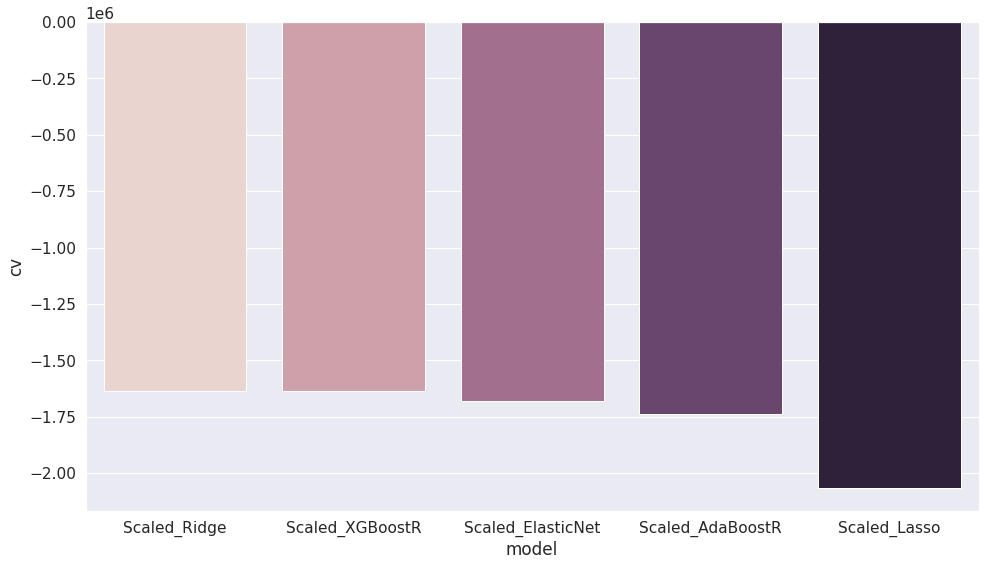

In [39]:
fig, ax = plt.subplots(1,1,sharey=False,figsize=(16,9))

bar = sns.barplot(x=evaluate['model'],y=evaluate['cv'],ax=ax,palette = sns.cubehelix_palette(evaluate.shape[0]))

From the chart above, models with the top 3 best negative rmse score are selected. All these models would be use in the ensemble VotingRegressor to further increase the cv score.
* XGBoost Regressor
* Elastic-Net Regressor
* Ridge Regressor

### **Voting regressor**

A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction

In [40]:
from sklearn.ensemble import VotingRegressor

In [41]:
## Creating a list for all combinations models
votings = []

##  All models
votings.append(("Scaled_all_models",Pipeline([("Scaler",StandardScaler()),
                                      ("Votings",VotingRegressor([("XGBoostR",XGBR_grid.best_estimator_),
                                                                  ("AdaBoostR", AdaBoostR_grid.best_estimator_),
                                                                  ("Ridge",ridge_grid.best_estimator_)
                                                                 ])                                  
                                    )])))


### Combinations of two estimators

## Combination of RandomForestRegressor with  BaggingRegressor & GradientBoostRegressor
votings.append(("Scaled_XGBR_AB",Pipeline([("Scaler",StandardScaler()),
                                      ("Votings",VotingRegressor([("XGBoostR",XGBR_grid.best_estimator_),
                                                                  ("AdaBoostR", AdaBoostR_grid.best_estimator_)
                                                                 ]))])
               ))

votings.append(("Scaled_XGBR_R",Pipeline([("Scaler",StandardScaler()),
                                      ("Votings",VotingRegressor([("XGBoostR",XGBR_grid.best_estimator_),
                                                                  ("Ridge",ridge_grid.best_estimator_)
                                                                 ]))])))

votings.append(("Scaled_AB_R",Pipeline([("Scaler",StandardScaler()),
                                      ("Votings",VotingRegressor([("AdaBoostR", AdaBoostR_grid.best_estimator_),
                                                                  ("Ridge",ridge_grid.best_estimator_)
                                                                 ]))])))

In [42]:
## Create dataframe for the cross validate score
evaluate_vote = pd.DataFrame(columns=["model","cv","std"])

## Fitting all the combination models
for name, model in votings:
    kfold = KFold(n_splits=10,random_state=42)
    
    cv = cross_val_score(model,X_train,y_train, cv=kfold, scoring="neg_root_mean_squared_error",n_jobs=-1)
    
    row = evaluate_vote.shape[0]
    
    evaluate_vote.loc[row,"model"] = name
    evaluate_vote.loc[row,"cv"] = round(cv.mean(),4)
    evaluate_vote.loc[row,"std"] = "+- {}".format(round(cv.std(),5))
    
evaluate_vote = evaluate_vote.sort_values("cv",ascending=False)
evaluate_vote

,model,cv,std
2,Scaled_XGBR_R,-1.58338e+06,+- 329356.62334
0,Scaled_all_models,-1.61286e+06,+- 337277.19759
3,Scaled_AB_R,-1.63216e+06,+- 348670.70376
1,Scaled_XGBR_AB,-1.66515e+06,+- 336083.60649


It seems like XGBoost with standardized dataset perform the best compared to all of the ensemble estimators. We will use XGBoost estimator to predict the test dataset for our submission

In [43]:
best_model = Pipeline([("Scaler",StandardScaler()),
                                      ("Votings",VotingRegressor([("XGBoostR",XGBR_grid.best_estimator_),
                                                                  ("AdaBoostR", AdaBoostR_grid.best_estimator_)
                                                                 ]))])
## Fit the model 
best_model = best_model.fit(train,y) # fit the model with all the train datase

## Submission
submission = pd.read_csv("/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv")
submission.iloc[:,1] = best_model.predict(test)
submission.to_csv('submission', index=False)
submission

,Id,Prediction
0,0,3.500546e+06
1,1,3.242323e+06
2,2,4.057545e+06
3,3,3.580414e+06
4,4,4.447501e+06
...,...,...
99995,99995,4.954828e+06
99996,99996,3.516128e+06
99997,99997,4.308418e+06
99998,99998,5.231962e+06
